In [407]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [797]:
import argparse
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import torch
import random
import pickle
import glob
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
import torch.nn as nn
import json
import jsonlines as jsonl

import config
import utils

from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import stanza
from networkx.drawing.nx_pydot import graphviz_layout
from torchtext import vocab as vocab
import torchtext

In [134]:
glove = {}
emb_file = config.GLOVE
with open(emb_file, 'r', encoding="utf-8") as fo:
    lines = fo.readlines()
    for line in tqdm(lines):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [412]:
print(glove["obama"][:6])
print(glove["unk"][:6])
print(len(glove))
# to do handle OOV embedding

[-0.2028   0.44239  0.61904 -0.11624 -0.33635 -0.24591]
[ 0.98379  0.3092  -0.2141   0.73205  0.70425 -0.40901]
1917494


In [410]:
data_file=config.DEV_MA_FILE
emb=config.GLOVE
parser=None
save=False
target=config.PDEV_MA_FILE

In [411]:
with open(data_file) as fo:
    raw_lines = fo.readlines()
    json_data = [json.loads(line) for line in raw_lines]
print(json_data[0][config.idf])

63735n


In [ ]:
stanza.download('zh')

In [413]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2020-08-03 18:41:05 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-03 18:41:05 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-03 18:41:05 INFO: Use device: gpu
2020-08-03 18:41:05 INFO: Loading: tokenize
2020-08-03 18:41:06 INFO: Loading: pos
2020-08-03 18:41:07 INFO: Loading: lemma
2020-08-03 18:41:07 INFO: Loading: depparse
2020-08-03 18:41:08 INFO: Done loading processors!


In [424]:
dep_r = [line for line in dir(nlp(json_data[0][config.hf]).sentences[0]) if "dep" in line]
print(dep_r)
print((nlp(json_data[0][config.hf]).sentences[0]).dependencies_string())
nlp(json_data[0][config.hf]).sentences[0].print_dependencies()

['_dependencies', 'build_dependencies', 'dependencies', 'dependencies_string', 'print_dependencies']
('Everyone', '3', 'nsubj')
('really', '3', 'advmod')
('likes', '0', 'root')
('the', '6', 'det')
('newest', '6', 'amod')
('benefits', '3', 'obj')
('Everyone', '3', 'nsubj')
('really', '3', 'advmod')
('likes', '0', 'root')
('the', '6', 'det')
('newest', '6', 'amod')
('benefits', '3', 'obj')


In [70]:
preprocessed_data = []
for data in json_data:
    #process_sentance()
    pass

In [420]:
utils.print_compact_dep(doc)

id: 1	word: Barack	head id: 4	head: born	deprel: nsubj:pass
id: 2	word: Obama	head id: 1	head: Barack	deprel: flat
id: 3	word: was	head id: 4	head: born	deprel: aux:pass
id: 4	word: born	head id: 0	head: root	deprel: root
id: 5	word: in	head id: 6	head: Hawaii	deprel: case
id: 6	word: Hawaii	head id: 4	head: born	deprel: obl
id: 7	word: .	head id: 4	head: born	deprel: punct
id: 1	word: He	head id: 3	head: elected	deprel: nsubj:pass
id: 2	word: was	head id: 3	head: elected	deprel: aux:pass
id: 3	word: elected	head id: 0	head: root	deprel: root
id: 4	word: president	head id: 3	head: elected	deprel: xcomp
id: 5	word: in	head id: 6	head: 2008	deprel: case
id: 6	word: 2008	head id: 3	head: elected	deprel: obl
id: 7	word: .	head id: 3	head: elected	deprel: punct


In [425]:
s3_exp = "I am a dog. He is a dog. She is a cat."

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[(0, 4), (0, 6), (4, 1), (4, 2), (4, 3), (4, 5), (6, 10), (6, 12), (10, 7), (10, 8), (10, 9), (10, 11), (12, 16), (16, 13), (16, 14), (16, 15), (16, 17)]


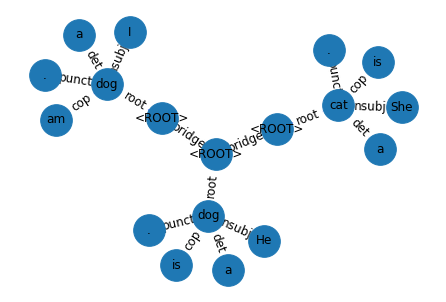

In [439]:
dep_s3 = utils.text2dep(s3_exp, nlp)
utils.draw(dep_s3)

In [430]:
ANLI_example = "Kwon So-hyun (born August 30, 1994), is a South Korean singer and actress. She was known as a member of the South Korean girl group 4Minute, under Cube Entertainment. She is also a former member of the South Korean girl group, Orange. Before June 15, 2016 (end of her contract with Cube), Sohyun left 4Minute and the record label along with members Nam Ji-hyun, Heo Ga-yoon, and Jeon Ji-yoon."

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
[(0, 15), (0, 19), (1, 2), (1, 4), (4, 3), (4, 5), (5, 6), (5, 7), (5, 8), (5, 9), (15, 1), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 17), (15, 18), (17, 16), (19, 22), (19, 39), (22, 20), (22, 21), (22, 25), (22, 38), (25, 23), (25, 24), (25, 31), (25, 34), (25, 37), (31, 26), (31, 27), (31, 28), (31, 29), (31, 30), (31, 33), (33, 32), (37, 35), (37, 36), (39, 45), (39, 55), (45, 40), (45, 41), (45, 42), (45, 43), (45, 44), (45, 51), (45, 54), (50, 49), (51, 46), (51, 47), (51, 48), (51, 50), (51, 52), (51, 53), (55, 71), (57, 56), (57, 58), (57, 59), (57, 60), (57, 62), (62, 61), (62, 65), (62, 68), (65, 63

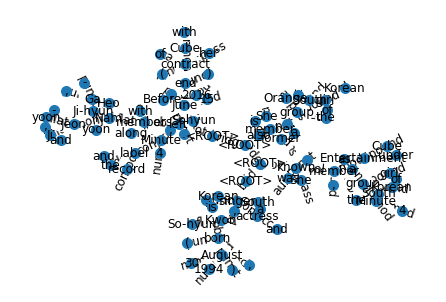

In [440]:
dep_anli_big = utils.text2dep(ANLI_example, nlp)
utils.draw(dep_anli_big, node_size=100, save_img_file='big_anli_test_dpe.png')

In [442]:
dep.edge_attr

[(4, 1, 'nsubj'),
 (4, 2, 'cop'),
 (4, 3, 'det'),
 (0, 4, 'root'),
 (4, 5, 'punct'),
 (10, 7, 'nsubj'),
 (10, 8, 'cop'),
 (10, 9, 'det'),
 (6, 10, 'root'),
 (10, 11, 'punct'),
 (0, 6, 'bridge'),
 (16, 13, 'nsubj'),
 (16, 14, 'cop'),
 (16, 15, 'det'),
 (12, 16, 'root'),
 (16, 17, 'punct'),
 (6, 12, 'bridge')]

In [473]:
def load_glove_vector(glove_embedding_file = config.GLOVE, dimension=config.GLOVE_DIMENSION, save_vocab = config.GLOVE_VOCAB, save_word2id = config.GLOVE_WORD2ID, save_dict=True):
    words = []
    idx = 0
    word2idx = {}
    glove = []
    #glove = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

    with open(glove_embedding_file, 'r') as fo:
        lines = fo.readlines()
        # add [UNK] handler
        words.append("[UNK]")
        word2idx["[UNK]"] = idx
        glove.append(np.zeros(300)) # 300 is vector dimension
        idx += 1
        # add [ROOT] handler
        words.append("[ROOT]")
        word2idx["[ROOT]"] = idx
        glove.append(np.zeros(300)) # 300 is vector dimension
        idx += 1
        # load vectors
        for line in tqdm(lines):
            line = line.split()
            word = line[0]
            words.append(word)
            word2idx[word] = idx
            vector = np.asarray(line[1:], "float32")
            glove.append(vector)
            idx += 1
    #glove = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
    #glove.flush()
    if save_dict == True:
        pickle.dump(words, open(config.GLOVE_ROOT / config.GLOVE_VOCAB, 'wb'))
        pickle.dump(word2idx, open(config.GLOVE_ROOT / config.GLOVE_WORD2ID, 'wb'))
    # later can load as 
    return glove, words, word2idx, idx

In [479]:
glove, words, word2idx, idx = utils.load_glove_vector()

In [480]:
print(words[0], word2idx['[UNK]'], glove[word2idx['[UNK]']][:5])

[UNK] 0 [0. 0. 0. 0. 0.]


In [481]:
print(words[1], word2idx[','], glove[word2idx[',']][:5])

, 1 [ 0.18378  -0.12123  -0.11987   0.015227 -0.19121 ]


In [580]:
glove = torch.tensor(glove, dtype=torch.float32) # dtype should be torch.float32

In [581]:
print(glove.size())

torch.Size([1917495, 300])


In [727]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove, freeze=True)
        self.conv1 = GCNConv(300, 16)
        self.conv2 = GCNConv(16, 3)

    def forward(self, data):
        x, edge_index, nodes = data.x, data.edge_index, data.node_attr
        #x = torch.tensor([ word2idx[y] if y in word2idx.keys() else word2idx["[UNK]"] for  in nodes.])
        x = self.embedding(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [728]:
from torch_geometric.data import Dataset

class SynNLI_Dataset(Dataset):
    def __init__(self, root, nlp=None):
        super(self).__init__(root, transform, pre_transform)
        

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        pass

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]

In [745]:
from torch_geometric.data import Data, DataLoader

data_list = [utils.text2dep("I am a person.", nlp, word2idx=word2idx), utils.text2dep("He is a dog. 123 bla saar kher hjaklehakejazzzzzzzzzzzzzz", nlp, word2idx=word2idx),  utils.text2dep(ANLI_example, nlp, word2idx=word2idx)]
loader = DataLoader(data_list, batch_size=32)

In [746]:
next(iter(loader)).x.size()

torch.Size([113])

In [747]:
model = Net()

In [750]:
model(next(iter(loader))).size()

torch.Size([113, 3])

In [749]:
dep = utils.text2dep("test, oov zzzzzzzzz", nlp, word2idx=word2idx)
print(dep.node_attr)
print(dep.x)

['[ROOT]', 'test', ',', 'oov', 'zzzzzzzzz']
tensor([     0,    667,      1, 444653, 285648])


In [ ]:
todo 8/4
multi-q
dataset-preprocessimng all (save as jsonl)
ask about SICK dataset solved? done
paper study on multiq 


In [787]:
print(json_data[0])

{'annotator_labels': ['neutral', 'entailment', 'neutral', 'neutral', 'neutral'], 'genre': 'slate', 'gold_label': 'neutral', 'pairID': '63735n', 'promptID': '63735', 'sentence1': 'The new rights are nice enough', 'sentence1_binary_parse': '( ( The ( new rights ) ) ( are ( nice enough ) ) )', 'sentence1_parse': '(ROOT (S (NP (DT The) (JJ new) (NNS rights)) (VP (VBP are) (ADJP (JJ nice) (RB enough)))))', 'sentence2': 'Everyone really likes the newest benefits ', 'sentence2_binary_parse': '( Everyone ( really ( likes ( the ( newest benefits ) ) ) ) )', 'sentence2_parse': '(ROOT (S (NP (NN Everyone)) (VP (ADVP (RB really)) (VBZ likes) (NP (DT the) (JJS newest) (NNS benefits)))))'}


In [800]:
def process_one_example(data, nlp):
    ret = {}
    ret[config.idf] = data[config.idf]
    ret[config.ph] = nlp(data[config.pf])
    ret[config.hf] = nlp(data[config.hf])
    ret[config.lf] = config.label_to_id[data[config.lf]]
    return ret

In [805]:
import utils

In [807]:
#x = utils.process_data(function_test=False)

2020-08-04 17:46:15 INFO: Downloading default packages for language: en (English)...
2020-08-04 17:46:16 INFO: File exists: /root/stanza_resources/en/default.zip.
2020-08-04 17:46:22 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-08-04 17:46:22 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-04 17:46:22 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-04 17:46:22 INFO: Use device: gpu
2020-08-04 17:46:22 INFO: Loading: tokenize
2020-08-04 17:46:22 INFO: Loading: pos
2020-08-04 17:46:23 INFO: Loading: lemma
2020-08-04 17:46:23 INFO: Loading: depparse
2020-08-04 17:46:24 INFO: Done loading processors!


In [811]:
x = utils.parse_data(function_test=False)

2020-08-04 18:24:04 INFO: Downloading default packages for language: en (English)...
2020-08-04 18:24:05 INFO: File exists: /root/stanza_resources/en/default.zip.
2020-08-04 18:24:11 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-08-04 18:24:11 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-04 18:24:11 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-04 18:24:11 INFO: Use device: gpu
2020-08-04 18:24:11 INFO: Loading: tokenize
2020-08-04 18:24:11 INFO: Loading: pos
2020-08-04 18:24:12 INFO: Loading: lemma
2020-08-04 18:24:12 INFO: Loading: depparse
2020-08-04 18:24:13 INFO: Done loading processors!


file /work/2020-IIS-NLU-internship/MNLI/data/MNLI_Stanza/pre_multinli_1.0_dev_matched.jsonl already exist
if u still want to procceed, add force_exe=True in function arg
exiting


In [815]:
glove[word2idx["good"]]@glove[word2idx["excellent"]]

tensor(39.7453)

In [816]:
glove[word2idx["good"]]@glove[word2idx["bad"]]

tensor(37.2005)

In [819]:
glove[word2idx["good"]]@glove[word2idx["nice"]]

tensor(41.1199)

In [818]:
glove[word2idx["good"]]@glove[word2idx["dog"]]

tensor(27.7168)